### Using Neural Networks

Imports

In [252]:
# conda install -c pytorch torchvision 

In [253]:
## imports

import time
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [254]:
# loading the dataset

df = pd.read_csv('data/archive.zip')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [255]:
df.shape

(303, 14)

In [256]:
## getting the features

X = df.drop(labels='target', axis=1)
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [257]:
## labels 
y = df['target']

In [258]:
## splitting training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272, 13), (31, 13), (272,), (31,))

In [259]:
## scaling the continuous features

numerical_features = ['age', 'trestbps', "chol", "thalach", "oldpeak"]

numeric_transformer = Pipeline(steps= [
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features)
        ], remainder='passthrough')

In [260]:
## scaled features

X_transform = preprocessor.fit_transform(X_train)

In [261]:
## Converting dataset to tensor

X_train_tnsr = torch.tensor(X_transform, dtype=torch.float32)
y_train_tnsr = torch.tensor(np.array(y_train))

In [262]:
y_train_tnsr.dtype

torch.int64

Model Settings 

In [263]:
## Hyper-parameters

LEARNING_RATE = 0.001
NUM_EPOCHS = 500

NUM_FEATURES = 13
NUM_CLASSES = 2

In [264]:
### model

class MLP(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        self.in_features = in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes))
        
    def forward(self, X):
        logits = self.classifier(X)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
    def predict_(self, X):
        logits, probas = self.forward(X)
        predictions = torch.where(probas > .5, torch.tensor([1]), torch.tensor([0]))
        predictions = torch.argmax(predictions, dim=1)
        return predictions     
    
    def accuracy(self, X, y):
        predictions = self.predict_(X)
        total_correct = predictions == y
        return torch.true_divide(torch.sum(total_correct), total_correct.size(0))

In [265]:
## Model initialization

model = MLP(in_features=NUM_FEATURES, num_classes=NUM_CLASSES)

## optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [266]:
## Compute loss

def compute_loss(model, features, targets):
    curr_loss = 0
    with torch.no_grad():
        logits, probas = model(features)
        loss = F.cross_entropy(logits, targets)
        curr_loss += loss
    return float(curr_loss)/features.size(0)

In [315]:
## train the model 
## We only have small amount of datasets so we will train them all in one batch

features = X_train_tnsr
targets = y_train_tnsr

start_time = time.time()
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()


    # forward prop and back prop
    logits, probas = model(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

    
    cost = compute_loss(model, X_train_tnsr, y_train_tnsr)
    epoch_cost.append(cost)
    print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS} Train cost: {cost:.4f}")
    print(f"Time elapsed: {(time.time() - start_time)/60:.2f}min")

Epoch: 001/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 002/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 003/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 004/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 005/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 006/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 007/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 008/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 009/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 010/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 011/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 012/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 013/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 014/500 Train cost: 0.0001
Time elapsed: 0.00min
Epoch: 015/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 016/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 017/500 Train cost: 0.0000
Time elapsed: 0.00min
Epoch: 018/500 Train cost: 0.0000
Time elapsed: 

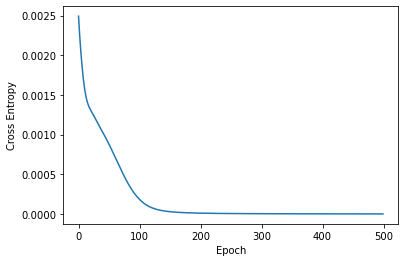

In [268]:
## Plotting the cost

plt.plot(epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [269]:
## Scaling the test set

X_test_transform = preprocessor.transform(X_test)

In [270]:
## Converting dataset to tensor

X_test_tnsr = torch.tensor(X_test_transform, dtype=torch.float32)
y_test_tnsr = torch.tensor(np.array(y_test))

In [271]:
## predicting the labels 

predictions = model.predict_(X_test_tnsr[:5,:])
true_labels = y_test_tnsr[:5]

print(f"Predictions {predictions} \nTrue labels {true_labels}")

Predictions tensor([1, 1, 0, 0, 0]) 
True labels tensor([1, 1, 1, 0, 0])


In [272]:
### measuring the accuracy

model.accuracy(X_test_tnsr, y_test_tnsr)

tensor(0.7419)

In [274]:
### Evaluating the model confusion matrix


predictions_for_transformed = model.predict_(X_test_tnsr)


cm = confusion_matrix(y_test_tnsr, predictions_for_transformed)

print(f"Model accuracy of Neural network: {accuracy_score(y_test, predictions_for_transformed)*100:.2f}%\n")
print(f"Confusion matrix:\n {cm}")
print(classification_report(y_test, predictions_for_transformed))

Model accuracy of Neural network: 74.19%

Confusion matrix:
 [[12  2]
 [ 6 11]]
              precision    recall  f1-score   support

           0       0.67      0.86      0.75        14
           1       0.85      0.65      0.73        17

    accuracy                           0.74        31
   macro avg       0.76      0.75      0.74        31
weighted avg       0.77      0.74      0.74        31



In [282]:
## Adding dropout to see how it effects the performance

### model

class MLP_(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLP_, self).__init__()
        
        self.num_classes = num_classes
        self.in_features = in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=128, out_features=num_classes))
        
    def forward(self, X):
        logits = self.classifier(X)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
    def predict_(self, X):
        logits, probas = self.forward(X)
        predictions = torch.where(probas > .5, torch.tensor([1]), torch.tensor([0]))
        predictions = torch.argmax(predictions, dim=1)
        return predictions     
    
    def accuracy(self, X, y):
        predictions = self.predict_(X)
        total_correct = predictions == y
        return torch.true_divide(torch.sum(total_correct), total_correct.size(0))

In [316]:
## Model initialization

model_dropout = MLP_(in_features=NUM_FEATURES, num_classes=NUM_CLASSES)

## optimizer
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=LEARNING_RATE)

## train the model 
## We only have small amount of datasets so we will train them all in one batch

features = X_train_tnsr
targets = y_train_tnsr

start_time = time.time()
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model_dropout.train()


    # forward prop and back prop
    logits, probas = model_dropout(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

    
    cost = compute_loss(model_dropout, X_train_tnsr, y_train_tnsr)
    epoch_cost.append(cost)
    print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS} Train cost: {cost:.4f}")
    print(f"Time elapsed: {(time.time() - start_time)/60:.2f}min")

Epoch: 001/500 Train cost: 0.0025
Time elapsed: 0.00min
Epoch: 002/500 Train cost: 0.0022
Time elapsed: 0.00min
Epoch: 003/500 Train cost: 0.0020
Time elapsed: 0.00min
Epoch: 004/500 Train cost: 0.0018
Time elapsed: 0.00min
Epoch: 005/500 Train cost: 0.0019
Time elapsed: 0.00min
Epoch: 006/500 Train cost: 0.0016
Time elapsed: 0.00min
Epoch: 007/500 Train cost: 0.0017
Time elapsed: 0.00min
Epoch: 008/500 Train cost: 0.0016
Time elapsed: 0.00min
Epoch: 009/500 Train cost: 0.0015
Time elapsed: 0.00min
Epoch: 010/500 Train cost: 0.0015
Time elapsed: 0.00min
Epoch: 011/500 Train cost: 0.0015
Time elapsed: 0.00min
Epoch: 012/500 Train cost: 0.0015
Time elapsed: 0.00min
Epoch: 013/500 Train cost: 0.0015
Time elapsed: 0.01min
Epoch: 014/500 Train cost: 0.0014
Time elapsed: 0.01min
Epoch: 015/500 Train cost: 0.0015
Time elapsed: 0.01min
Epoch: 016/500 Train cost: 0.0014
Time elapsed: 0.01min
Epoch: 017/500 Train cost: 0.0013
Time elapsed: 0.01min
Epoch: 018/500 Train cost: 0.0014
Time elapsed: 

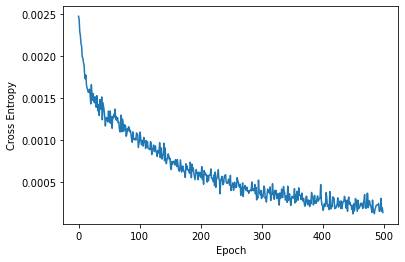

In [285]:
## Plotting the cost

plt.plot(epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [286]:
### Evaluating the model confusion matrix

## Dropout improved the performance by ~3%


predictions_for_transformed = model_dropout.predict_(X_test_tnsr)


cm = confusion_matrix(y_test_tnsr, predictions_for_transformed)

print(f"Model accuracy of Neural network: {accuracy_score(y_test, predictions_for_transformed)*100:.2f}%\n")
print(f"Confusion matrix:\n {cm}")
print(classification_report(y_test, predictions_for_transformed))

Model accuracy of Neural network: 77.42%

Confusion matrix:
 [[12  2]
 [ 5 12]]
              precision    recall  f1-score   support

           0       0.71      0.86      0.77        14
           1       0.86      0.71      0.77        17

    accuracy                           0.77        31
   macro avg       0.78      0.78      0.77        31
weighted avg       0.79      0.77      0.77        31



In [295]:
## Adding batch norm to see how it effects the performance

### model

class MLP_(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLP_, self).__init__()
        
        self.num_classes = num_classes
        self.in_features = in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=128, out_features=num_classes))
        
    def forward(self, X):
        logits = self.classifier(X)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
    def predict_(self, X):
        logits, probas = self.forward(X)
        predictions = torch.where(probas > .5, torch.tensor([1]), torch.tensor([0]))
        predictions = torch.argmax(predictions, dim=1)
        return predictions     
    
    def accuracy(self, X, y):
        predictions = self.predict_(X)
        total_correct = predictions == y
        return torch.true_divide(torch.sum(total_correct), total_correct.size(0))

In [ ]:
### Adding regularization to the same model to see if the generalization performance increases

## Model initialization

model_dropout = MLP_(in_features=NUM_FEATURES, num_classes=NUM_CLASSES)

## optimizer
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=LEARNING_RATE, weight_decay=0)

## train the model 
## We only have small amount of datasets so we will train them all in one batch

features = X_train_tnsr
targets = y_train_tnsr

start_time = time.time()
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model_dropout.train()


    # forward prop and back prop
    logits, probas = model_dropout(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

    
    cost = compute_loss(model_dropout, X_train_tnsr, y_train_tnsr)
    epoch_cost.append(cost)
    print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS} Train cost: {cost:.4f}")
    print(f"Time elapsed: {(time.time() - start_time)/60:.2f}min")

Epoch: 001/500 Train cost: 0.0025
Time elapsed: 0.00min
Epoch: 002/500 Train cost: 0.0021
Time elapsed: 0.00min
Epoch: 003/500 Train cost: 0.0019
Time elapsed: 0.00min
Epoch: 004/500 Train cost: 0.0019
Time elapsed: 0.00min
Epoch: 005/500 Train cost: 0.0019
Time elapsed: 0.00min
Epoch: 006/500 Train cost: 0.0017
Time elapsed: 0.00min
Epoch: 007/500 Train cost: 0.0016
Time elapsed: 0.00min
Epoch: 008/500 Train cost: 0.0015
Time elapsed: 0.00min
Epoch: 009/500 Train cost: 0.0016
Time elapsed: 0.00min
Epoch: 010/500 Train cost: 0.0016
Time elapsed: 0.01min
Epoch: 011/500 Train cost: 0.0016
Time elapsed: 0.01min
Epoch: 012/500 Train cost: 0.0014
Time elapsed: 0.01min
Epoch: 013/500 Train cost: 0.0015
Time elapsed: 0.01min
Epoch: 014/500 Train cost: 0.0014
Time elapsed: 0.01min
Epoch: 015/500 Train cost: 0.0015
Time elapsed: 0.01min
Epoch: 016/500 Train cost: 0.0014
Time elapsed: 0.01min
Epoch: 017/500 Train cost: 0.0016
Time elapsed: 0.01min
Epoch: 018/500 Train cost: 0.0013
Time elapsed: 

In [311]:
### Evaluating the model confusion matrix

## Adding Batchnorm improved the performance by ~5%


predictions_for_transformed = model_dropout.predict_(X_test_tnsr)


cm = confusion_matrix(y_test_tnsr, predictions_for_transformed)

print(f"Model accuracy of Neural network: {accuracy_score(y_test, predictions_for_transformed)*100:.2f}%\n")
print(f"Confusion matrix:\n {cm}")
print(classification_report(y_test, predictions_for_transformed))

Model accuracy of Neural network: 83.87%

Confusion matrix:
 [[13  1]
 [ 4 13]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.93      0.76      0.84        17

    accuracy                           0.84        31
   macro avg       0.85      0.85      0.84        31
weighted avg       0.85      0.84      0.84        31



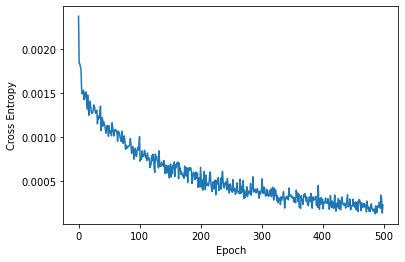

In [314]:
## Plotting the cost

plt.plot(epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()